In [154]:
import torch
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from scripts.gan import Generator

In [155]:
X = np.load('../data/X.npy')
X = torch.tensor(X, dtype=torch.float32)
y = np.load('../data/y.npy')
y = torch.tensor(y, dtype=torch.float32)

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G0 = Generator()
G0.load_state_dict(torch.load('../models/best_generator_regime0.pth'))
G0.to(device)

G1 = Generator()
G1.load_state_dict(torch.load('../models/best_generator_regime1.pth'))
G1.to(device);

In [157]:
def generate_day(regime):
    if regime == 0:
        G = G0
        std = X[y==0].std()
    elif regime == 1:
        G = G1
        std = X[y==1].std()
    else:
        raise ValueError('Invalid regime')
    
    z = torch.randn(1, 100).to(device)
    generated = G(torch.randn(1, 100, 1, 1, device=device))[:,:,:,25:-25].reshape(-1, 96).cpu() * std
    idx = np.random.randint(0, len(generated))
    return generated[idx].detach().numpy()

In [158]:
transition_matrix = np.array([[0.84255843, 0.15744157],
                              [0.1868932 , 0.8131068 ]])

In [163]:
regime = np.random.choice([0, 1], p=[2440 / (2440 + 2061), 2061 / (2440 + 2061)])
year = np.array([0])
timestamps = [pd.Timestamp('2050-01-01')]
for _ in range(365):
    day = generate_day(regime)
    year = np.concatenate((year, day.cumsum()+year[-1]))
    for _ in range(96):
        timestamps.append(timestamps[-1] + pd.Timedelta(minutes=15))
    regime = np.random.choice([0, 1], p=transition_matrix[regime])

df = pd.DataFrame({'Value': year}, index=timestamps)
df

,Value
2050-01-01 00:00:00,0.000000
2050-01-01 00:15:00,33.239544
2050-01-01 00:30:00,68.387856
2050-01-01 00:45:00,122.725800
2050-01-01 01:00:00,64.218582
...,...
2050-12-31 23:00:00,-32243.150391
2050-12-31 23:15:00,-32330.812500
2050-12-31 23:30:00,-32384.162109
2050-12-31 23:45:00,-32439.208984


In [164]:
window = 24*4*3
df['Moving Avg'] = df['Value'].rolling(window=window).mean()
df['Value'] = np.abs(df['Value'] - df['Moving Avg'])
df['Moving Std'] = df['Value'].rolling(window=window).std()
df['Moving Momentum'] = df['Value'].rolling(window=window).apply(lambda x: np.mean(np.diff(x)))
df.dropna(inplace=True)

In [165]:
generation = df[['Moving Std', 'Moving Momentum']].values
generation = (generation - generation.mean(axis=0)) / generation.std(axis=0)

with open('../models/hmm.pkl', 'rb') as f:
    model = pickle.load(f)
    
df["Regime"] = model.predict(generation)
df['Regime'] = df['Regime'].shift(-window // 2)
df['Regime'] = df['Regime'].ffill()

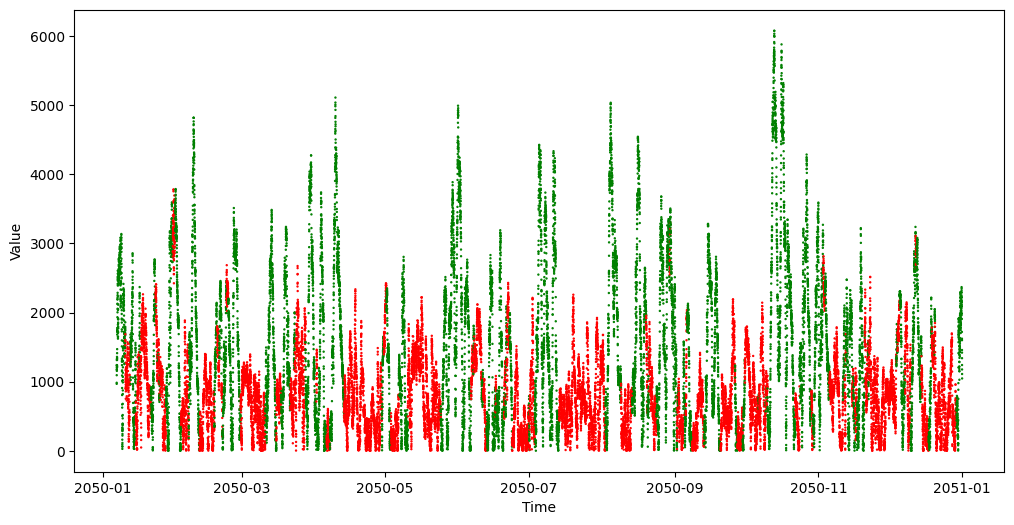

In [166]:
color_mapping = {0: 'g', 1: 'r'}

df['Color'] = df['Regime'].map(color_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Value'], c=df['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()